In [71]:
import tensorflow as tf
import os
import skimage.data
from skimage import transform
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt 

In [72]:
ROOT_PATH = './datasets/belgianTrafficSigns/'
train_data_directory = os.path.join(ROOT_PATH, 'train')
test_data_directory = os.path.join(ROOT_PATH, 'test')

### Define a function `load_data` for loading data and Labels in given dir.

In [73]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]
    
    images = []
    labels = []
    
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
            
    return images, labels

In [74]:
images, labels = load_data(train_data_directory)

# Make use of numpy to convert 
# the image and labels lists to arrays
# images = np.array(images)
# labels = np.array(labels)

In [75]:
# print(images.ndim, labels.ndim)
# print(images.size, labels.size)
# print(len(set(labels)))

## Visualizing the distribution of the images in the 62 labels.

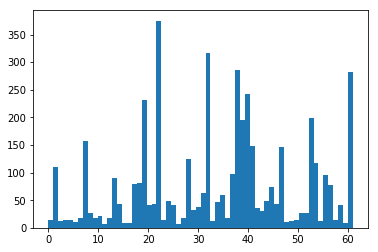

In [76]:
plt.hist(labels, 62)
plt.show()

## Visualizing some random images from the dataset

In [77]:
def show_n_random_images(images, n, cmap=False):
    # Create and array of 4 random digits from the dataset
    traffic_signs = [np.random.randint(len(images) - 1) for _ in range(n)]

    for i in range(len(traffic_signs)):
        image = images[traffic_signs[i]]

        plt.subplot(1, 4, i + 1)
        plt.axis('off')
        if(cmap):
            plt.imshow(image, cmap=cmap)
        else:
            plt.imshow(image)
        plt.subplots_adjust(wspace=0.5)
        plt.show()
        print("Shape: {0}, Min: {1}, Max: {2}".format(image.shape, image.min(), image.max()))

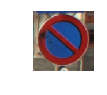

Shape: (105, 106, 3), Min: 13, Max: 255


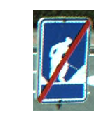

Shape: (144, 87, 3), Min: 0, Max: 255


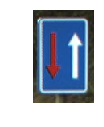

Shape: (116, 76, 3), Min: 15, Max: 255


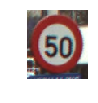

Shape: (85, 75, 3), Min: 20, Max: 255


In [78]:
show_n_random_images(images, 4)

### Display a single image for each of the 62 labels

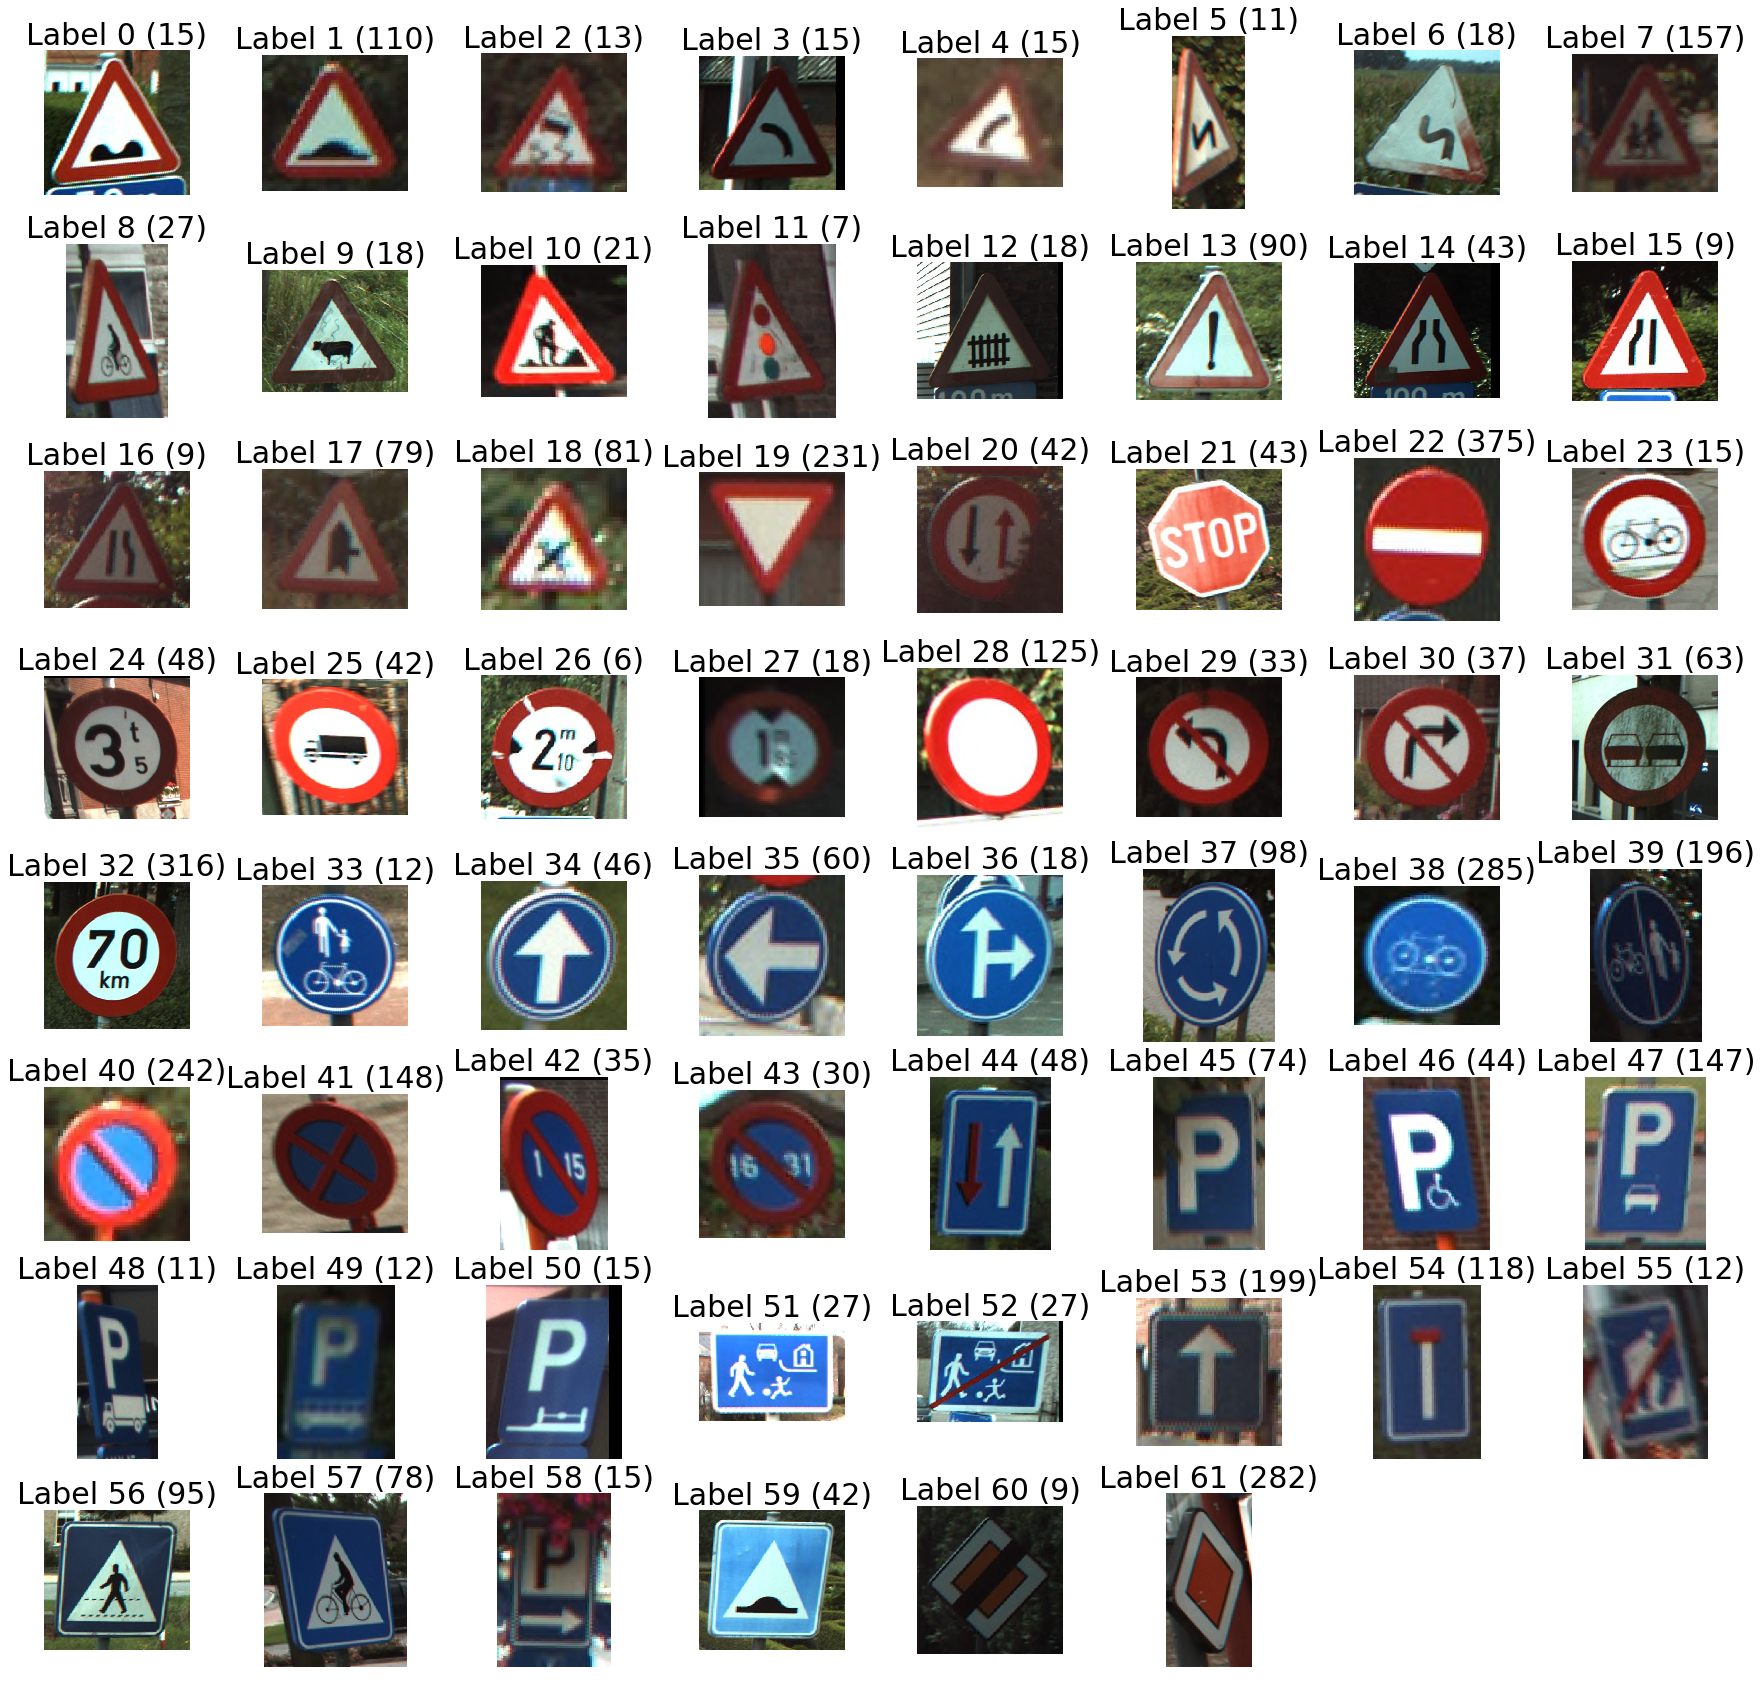

In [79]:
# Print one image per label
unique_labels = set(labels)

# Initialize the plots
plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.5)


# Initialize counter
i = 1

# For each unique label

for label in unique_labels:
    # You pick one image for each label
    image = images[labels.index(label)]
    
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    
    # Don't include axes
    plt.axis('off')
    
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(label, labels.count(label)), {'fontsize': 30})
    
    # Add 1 to the counter
    i += 1
    
    # And you plot this first image 
    plt.imshow(image)
    
plt.show()

Taking a closer look at the pictures above, it is clear that as depicted in the histogram above, the traffic signes with labels 22, 32, 38 and 61 have higher frequencies. Concretely, there are 375 instances of label 22, 316 instances with label 32 and 285 instances with laebl 38 and 282 instances with label 61.



## Feature Extraction

Recaping briefly on what was discovered in the  data visualization steps above. It was discovered that..

<ol>
    <li>The size of the images was unequal</li>
    <li>There are 62 labels or target values (as your labels start at 0 and end at 61)
</li>
    <li>The distribution of the traffic sign values is pretty unequal; There wasn’t really any connection between the signs that were heavily present in the dataset</li>
</ol>


Knowing this, it is a bit clear what needs to be improved ro the data to be ready to be fed into the a neural network or any other model.

One thing that needs to be done first is rescaling the images to same size, then converting the images in the `images` array all to greyscale. The color conversion will be done maily because the color doesn't matter much in a classification problem. However, it this were a detection problem, the colors will play a great role, thus the color conversion step wouldn't be necessary.

### 1. Rescaling Images

The problem of differing image sizes can easily be tackled by resizing the images. This can easily be achieved with the use of `skimage` or the `Scikit-Image Library`, which is a collection of algorithms for image processing.

Concretly, the `resize()` method of the  `transform` module of the library will be used for image resizing.

A new array named `images28` will be created to hold the new list of images, each have dimensions of `28x28`. 

In [80]:
def resize_images(images, width, height):
    images = [transform.resize(image, (width, height), mode='reflect') for image in images]
    return images

The above mehtod takes in an array of images, and returns a list of images containing images each of dimetions ```width x height```

In [81]:
images28 = resize_images(images, 28, 28)

The dimentions of images28 is <span class="badge">(4575, 28, 28, 3)</span>. This means that `images28` is a array of 4575 images, each of which has dimentions, 28x28x3. I.e, a width of 28px and height of 28px and a "thickness" of 3. The 3 respresents the <span class="text-danger">Red</span>, <span class="text-success">Green</span> and <span class="text-primary">Blue</span> components of its colors.

In [82]:

# Show the shape of the resulting array of images.
print(np.array(images28).shape)

# Show the shape of just a single random nth item in the list
print(np.array(images28)[9].shape)

(4575, 28, 28, 3)
(28, 28, 3)


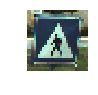

Shape: (28, 28, 3), Min: 0.04394257703081557, Max: 1.0


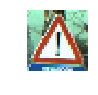

Shape: (28, 28, 3), Min: 0.04611344537815096, Max: 1.0


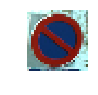

Shape: (28, 28, 3), Min: 0.02261904761904738, Max: 1.0


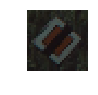

Shape: (28, 28, 3), Min: 0.04229691876750608, Max: 0.3511204481792715


In [83]:
show_n_random_images(images28, 4)

### 2. Image Conversion to Grayscale

Just like with the rescaling, the Scikit-Image library can help out with converting images from RGB to grayscale. In this case, it’s the color module with its `rgb2gray()` function that you need to use to get where you need to be.

In [84]:
def rgb_to_grayscale(images):
    # Convert `images28` to an array
    images = np.array(images)

    # Convert `images28` to grayscale
    images = rgb2gray(images)
    return images

In [85]:
images28 = rgb_to_grayscale(images28)

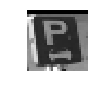

Shape: (28, 28), Min: 0.0, Max: 0.9997488839285713


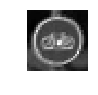

Shape: (28, 28), Min: 0.02682468037214885, Max: 0.538538755502201


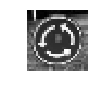

Shape: (28, 28), Min: 0.057553643707482754, Max: 0.996940922619048


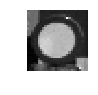

Shape: (28, 28), Min: 0.14544044817927188, Max: 0.6420850140055984


In [86]:
show_n_random_images(images28, 4, cmap="gray")

# <u>Deep Learning with Tensorflow</u>
After data visualization and normalization, now is the time to start building the actual neural network architecture with Tensorflow.

### 1. Modeling The Neural network

Tensorflow makes use of the <span class="badge">Graph()</span>. This function holds the computation graph of a set co computations to be performed later.

In this case, you set up a default context with the help of as_default(), which returns a context manager that makes this specific Graph the default graph. You use this method if you want to create multiple graphs in the same process: with this function, you have a global default graph to which all operations will be added if you don’t explicitly create a new graph.

To carry out the training of the neural network using Tensorflow, 

<ul>
    <li>First, you define placeholders for inputs and labels because you won’t put in the “real” data yet. Remember that placeholders are values that are unassigned and that will be initialized by the session when you run it. So when you finally run the session, these placeholders will get the values of your dataset that you pass in the run() function!</li>
    <br>
    
    <li>Then, you build up the network. You first start off by flattening the input with the help of the flatten() function, which will give you an array of shape <span class="badge">[None, 784]</span> instead of the <span class="badge">[None, 28, 28]</span>, which is the shape of your grayscale images.</li>
     <br>
    
    <li>After you have flattened the input, you construct a fully connected layer that generates logits of size [None, 62]. Logits is the function operates on the unscaled output of earlier layers and that uses the relative scale to understand the units is linear.</li>
     <br>
    
    <li>With the multi-layer perceptron built out, you can define the loss function. The choice for a loss function depends on the task that you have at hand: in this case, you make use of</li>
     <br>
     
    <div class="col-lg-12 text-success text-center" style="background-color: black; height: 50px">sparse_softmax_cross_entropy_with_logits()
</div>
 <br>

    <li>You also want to define a training optimizer; Some of the most popular optimization algorithms used are the Stochastic Gradient Descent (SGD), ADAM and RMSprop. Depending on whichever algorithm you choose, you’ll need to tune certain parameters, such as learning rate or momentum. In this case, you pick the ADAM optimizer, for which you define the learning rate at 0.001.
</li>
 <br>

    <li>Lastly, you initialize the operations to execute before going over to the training.</li>
    
</ul>

In [87]:
# Initialize Placeholders

x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# Flatten the input data
images_flat = tf.contrib.layers.flatten(x)

#fully connected layer
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

# Define a loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits))


# Defined the optimizer
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Convert logits to label indexes
correct_pred = tf.argmax(logits, 1)

# Define an accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", correct_pred)

images_flat:  Tensor("Flatten_5/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected_4/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean_7:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax_3:0", shape=(?,), dtype=int64)


## Running The Neural Network



In [ ]:
tf.set_random_seed(1234)
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(201):
        print('EPOCH', i)
        _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: images28, y: labels})
        if i % 10 == 0:
            print("Loss: {0}, Accuracy: {1}".format(loss, accuracy_val))
        print('DONE WITH EPOCH')



EPOCH 0
Loss: Tensor("Mean_7:0", shape=(), dtype=float32), Accuracy: 38.42841720581055
DONE WITH EPOCH
EPOCH 1
DONE WITH EPOCH
EPOCH 2
DONE WITH EPOCH
EPOCH 3
DONE WITH EPOCH
EPOCH 4
DONE WITH EPOCH
EPOCH 5
DONE WITH EPOCH
EPOCH 6
DONE WITH EPOCH
EPOCH 7
DONE WITH EPOCH
EPOCH 8
DONE WITH EPOCH
EPOCH 9
DONE WITH EPOCH
EPOCH 10
Loss: Tensor("Mean_7:0", shape=(), dtype=float32), Accuracy: 26.939016342163086
DONE WITH EPOCH
EPOCH 11
DONE WITH EPOCH
EPOCH 12
DONE WITH EPOCH
EPOCH 13
DONE WITH EPOCH
EPOCH 14
DONE WITH EPOCH
EPOCH 15
DONE WITH EPOCH
EPOCH 16
DONE WITH EPOCH
EPOCH 17
DONE WITH EPOCH
EPOCH 18
DONE WITH EPOCH
EPOCH 19
DONE WITH EPOCH
EPOCH 20
Loss: Tensor("Mean_7:0", shape=(), dtype=float32), Accuracy: 31.80961799621582
DONE WITH EPOCH
EPOCH 21
DONE WITH EPOCH
EPOCH 22
DONE WITH EPOCH
EPOCH 23
DONE WITH EPOCH
EPOCH 24
DONE WITH EPOCH
EPOCH 25
DONE WITH EPOCH
EPOCH 26
DONE WITH EPOCH
EPOCH 27
DONE WITH EPOCH
EPOCH 28
DONE WITH EPOCH
EPOCH 29
DONE WITH EPOCH
EPOCH 30
Loss: Tensor(

## Testing the neural network

In [ ]:
# Import `matplotlib`
import matplotlib.pyplot as plt
import random

# Pick 10 random images
sample_indexes = random.sample(range(len(images28)), 10)
sample_images = [images28[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "correct_pred" operation
predicted = sess.run([correct_pred], feed_dict={x: sample_images})[0]
                        
# Print the real and predicted labels
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i],  cmap="gray")

plt.show()

## Measure Accuracy on test Data set.

In [ ]:
# Import `skimage`
from skimage import transform

# Load the test data
test_images, test_labels = load_data(test_data_directory)

# Transform the images to 28 by 28 pixels
test_images28 = resize_images(test_images, 28, 28 ) # [transform.resize(image, (28, 28)) for image in test_images]

# Convert to grayscale
test_images28 = rgb_to_grayscale(test_images28)

# Run predictions against the full test set.
predicted = sess.run([correct_pred], feed_dict={x: test_images28})[0]

# Calculate correct matches 
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])

# Calculate the accuracy
accuracy = match_count / len(test_labels)

# Print the accuracy
print("Accuracy: {:.3f}".format(accuracy))

sess.close()